In [2]:
import os
import pickle
import shutil
import re
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from dataloader import GetDocumentObj, DictObj, GetTensor

In [2]:
USE_CUDA = torch.cuda.is_available()
GPU_ID = 2

USE_CUDA

True

In [4]:
top_path = "top_B.parse"
u20_path = "u20_B.parse"

In [5]:
label_dict = {top_path:0, u20_path:1}
list_document = []; start_date = None ; end_date = None
list_document, start_date, end_date = GetDocumentObj(list_document, top_path, label_dict[top_path], start_date, end_date)
list_document, start_date, end_date = GetDocumentObj(list_document, u20_path, label_dict[u20_path], start_date, end_date)

documents_obj = DictObj()
documents_obj.SetDict(list_document)    
time_tensor, loc_tensor, person_organ_tensor, morph_tensor, list_label = GetTensor(list_document, documents_obj, start_date, end_date)

len(list_label)

2274

In [6]:
time_tensor2, _, _, _, _ = GetTensor(list_document, documents_obj, start_date, end_date, 1)

In [10]:
time_tensor[0:5]



Columns 0 to 9 
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000

Columns 10 to 19 
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000

Columns 20 to 29 
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000 

In [11]:
time_tensor2[0:5]



Columns 0 to 9 
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000

Columns 10 to 19 
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000

Columns 20 to 29 
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000 

In [5]:
# 갯수 맞추기
top_indices = [i for i, x in enumerate(list_label) if x == 0]
u20_indices = [i for i, x in enumerate(list_label) if x == 1]

top_doc_size = len(top_indices)
u20_doc_size = len(u20_indices)

print('탑 문서 수 : ', top_doc_size)
print('u20 문서 수 : ', u20_doc_size)

탑 문서 수 :  1821
u20 문서 수 :  453


In [6]:
# 나머지 뷰 갯수 맞추기
top_morph_list = [[morph_tensor[i], 0] for i in top_indices]
u20_morph_list = [[morph_tensor[i], 1] for i in u20_indices]

top_morph_list = random.sample(top_morph_list, u20_doc_size)

morph_list = top_morph_list + u20_morph_list
random.shuffle(morph_list)

morph_data = [data[0] for data in morph_list]
morph_data = torch.stack(morph_data, dim=0).cuda(GPU_ID)
morph_label = [data[1] for data in morph_list]

print('나머지 뷰 : ', morph_data.size())

나머지 뷰 :  torch.Size([906, 10802])


In [7]:
# 시간 뷰 갯수 맞추기
top_time_list = [[time_tensor[i], 0] for i in top_indices]
u20_time_list = [[time_tensor[i], 1] for i in u20_indices]

top_time_list = random.sample(top_time_list, u20_doc_size)

time_list = top_time_list + u20_time_list
random.shuffle(time_list)

time_data = [data[0] for data in time_list]
time_data = torch.stack(time_data, dim=0).cuda(GPU_ID)
time_label = [data[1] for data in time_list]

print('시간 뷰 : ', time_data.size())

시간 뷰 :  torch.Size([906, 180])


In [116]:
cluster_time_list = top_time_list + u20_time_list
random.shuffle(cluster_time_list)
cluster_time_data = [data[0] for data in cluster_time_list]
cluster_time_data = torch.stack(cluster_time_data, dim=0).cuda(GPU_ID)
cluster_time_label = [data[1] for data in cluster_time_list]

with open("cluster_time_data.txt", "w") as fp:
    for line in cluster_time_list:
        for element in line[0]:
            fp.write('{:.4f}\t'.format(element))
        fp.write('\n')

In [117]:
cluster_morph_list = top_morph_list + u20_morph_list
random.shuffle(cluster_morph_list)
cluster_morph_data = [data[0] for data in cluster_morph_list]
cluster_morph_data = torch.stack(cluster_morph_data, dim=0).cuda(GPU_ID)
cluster_morph_label = [data[1] for data in cluster_morph_list]

with open("cluster_morph_data.txt", "w") as fp:
    for line in cluster_morph_list:
        for element in line[0]:
            fp.write('{:.4f}\t'.format(element))
        fp.write('\n')

In [88]:
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_size):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, int(input_size/2)),
            nn.Linear(int(input_size/2), int(input_size/4)))
        self.decoder = nn.Sequential(
            nn.Linear(int(input_size/4), int(input_size/2)),
            nn.Linear(int(input_size/2), input_size), nn.ReLU())  # ReLU, Tanh

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def getRepresentation(self, x):
        x = self.encoder(x)
        return x

In [89]:
TOTAL_DATA_NUM = u20_doc_size*2
TRAIN_DATA_NUM = int(TOTAL_DATA_NUM*0.8)
TEST_DATA_NUM = TOTAL_DATA_NUM - TRAIN_DATA_NUM

In [90]:
def getBatch(data, batch_size=128, isTrain=True):
    if isTrain:
        startIdx = 0
        endIdx = TRAIN_DATA_NUM
    else:
        startIdx = TRAIN_DATA_NUM
        endIdx = len(data)
        
    for idx in range(startIdx, endIdx, batch_size):
        batch = data[idx:min(idx + batch_size, endIdx)]
        yield batch

In [91]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [326]:
def trainModel(model, inputs, num_epoch=200, batch_size=16, lr=1e-3, w_decay=1e-5, isPrintEval=False, isPrint=True, isPlot=True,
               print_every=5, plot_every=5):
    BATCH_SIZE = batch_size
    NUM_EPOCH = num_epoch
    
    LR = 1e-3
    WEIGHT_DECAY = 1e-5
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    
    for epoch in tqdm(range(1, NUM_EPOCH+1)):
        for batch in getBatch(inputs, batch_size=BATCH_SIZE):
            batch = Variable(batch).cuda(GPU_ID)
            # ===================forward=====================
            output = model(batch).cuda(GPU_ID)
            loss = criterion(output, batch)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            print_loss_total += loss.data[0]
            plot_loss_total += loss.data[0]
            
        # ===================log========================
        if epoch % print_every == 0 and isPrint:
            print_loss_avg = print_loss_total / (print_every*batch_size)
            print_loss_total = 0
            print_eval_loss_avg = -1
            if isPrintEval:
                print_eval_loss_avg = evalModel(model, inputs)[0].data.tolist()[0]/TEST_DATA_NUM
            print('epoch [{}/{}], loss:{:.5f}, eval_loss:{:.5f}'.format(epoch, NUM_EPOCH, print_loss_avg, print_eval_loss_avg))
        
        if epoch % plot_every == 0 and isPlot:
            plot_loss_avg = plot_loss_total / (print_every*batch_size)
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    if isPlot:
        showPlot(plot_losses)
    #torch.save(model.state_dict(), './sim_autoencoder.pth')

In [255]:
def evalModel(model, inputs):
    BATCH_SIZE = 256
    
    criterion = nn.MSELoss()
    
    loss = 0
    result = []
    for batch in getBatch(inputs, batch_size=BATCH_SIZE, isTrain=False):
        batch = Variable(torch.FloatTensor(batch.tolist())).cuda(GPU_ID)
        
        output = model(batch).cuda(GPU_ID)
        result.append(output)
        loss += criterion(output, batch)[0]
        
    return loss, result

In [334]:
n_epoch_list = [300]
n_test = 1

In [335]:
epoch_acc_list = []
epoch_acc_avg_list = []

for n_epoch in n_epoch_list:
    
    acc_list = []
    for t in range(n_test):
        # 시간뷰 (180 dim)
        # Training
        inputs = time_data
        INPUT_SIZE = inputs.size()[1]
        
        model_time = SimpleAutoencoder(INPUT_SIZE).cuda(GPU_ID)
        trainModel(model_time, inputs, num_epoch=n_epoch, print_every=102, plot_every=102, isPrint=False, isPlot=False)
        
        # Clustering
        inputs = Variable(cluster_time_data).cuda(GPU_ID)
        batch_rep = model_time.getRepresentation(inputs).data.tolist()
        
        kmeans_time = KMeans(n_clusters=2, random_state=0).fit(batch_rep)
        gen_label_time = kmeans_time.labels_
        
        correct_cnt_morph = max([sum([1 for tar, gen in zip(cluster_time_label, gen_label_time) if tar == gen]),
                                 sum([1 for tar, gen in zip(cluster_time_label, gen_label_time) if tar != gen])])
        acc_morph = correct_cnt_morph / TOTAL_DATA_NUM
        acc_list.append(acc_morph)
    
    epoch_acc_list.append(acc_list)
    epoch_acc_avg_list.append(sum(acc_list) / n_test)

100%|██████████| 300/300 [00:37<00:00,  7.90it/s]


In [330]:
list(zip(n_epoch_list, epoch_acc_avg_list))

[(10, 0.5960264900662252), (20, 0.5540838852097131), (30, 0.8642384105960265)]

In [336]:
list(zip(n_epoch_list, epoch_acc_avg_list))

[(300, 0.8520971302428256)]

In [337]:
n_epoch = 10

In [338]:
inputs = time_data
INPUT_SIZE = inputs.size()[1]

model_time = SimpleAutoencoder(INPUT_SIZE).cuda(GPU_ID)
trainModel(model_time, inputs, num_epoch=n_epoch, print_every=102, plot_every=102, isPrint=False, isPlot=False)


100%|██████████| 10/10 [00:00<00:00, 10.17it/s]


In [317]:
# Clustering
inputs = Variable(cluster_time_data).cuda(GPU_ID)
batch_rep = model_time.getRepresentation(inputs)

batch_rep[0:10]

Variable containing:

Columns 0 to 9 
 0.4163  0.1423  0.2675 -0.9332 -0.7013  0.0287 -0.3476  0.5854  0.6664  0.0532
-0.3041 -0.3994 -0.5525 -0.2535 -0.6925  0.4107 -0.1130  0.5156  0.2931  0.0101
-0.3041 -0.3994 -0.5525 -0.2535 -0.6925  0.4107 -0.1130  0.5156  0.2931  0.0101
 0.0143 -0.2531 -0.2548 -0.6115 -0.8052  0.2831 -0.2114  0.5732  0.4245 -0.0146
-0.3041 -0.3994 -0.5525 -0.2535 -0.6925  0.4107 -0.1130  0.5156  0.2931  0.0101
-0.3606 -0.4095 -0.5999 -0.1775 -0.6487  0.4291 -0.0919  0.4979  0.2737  0.0245
 0.4163  0.1423  0.2675 -0.9332 -0.7013  0.0287 -0.3476  0.5854  0.6664  0.0532
 0.2835  0.8841  0.9959 -0.2389 -0.1301 -0.5372 -0.6970  0.3201  0.6392  0.1369
 0.5513  0.5115  0.6909 -0.8942 -0.4811 -0.2226 -0.4836  0.5427  0.8060  0.1349
 0.6090 -0.0102 -0.0413 -0.8638  0.1173 -1.1606  0.3989 -0.1331 -0.4039 -0.3913

Columns 10 to 19 
 0.8163  0.0946  0.2205  0.5516 -0.4612 -0.4865  0.4240  0.9357  0.7644  0.6424
 0.9595 -0.2600 -0.4276  0.3069  0.1719 -0.6785  0.4339  0.3427

In [318]:
cluster_time_label[0:10]

[1, 0, 0, 0, 0, 0, 1, 1, 1, 1]

In [ ]:
kmeans_time = KMeans(n_clusters=2, random_state=0).fit(batch_rep)
gen_label_time = kmeans_time.labels_

correct_cnt_morph = max([sum([1 for tar, gen in zip(cluster_time_label, gen_label_time) if tar == gen]),
                         sum([1 for tar, gen in zip(cluster_time_label, gen_label_time) if tar != gen])])
acc_morph = correct_cnt_morph / TOTAL_DATA_NUM
acc_list.append(acc_morph)

In [280]:
for tar, gen in zip(cluster_time_label, gen_label_time):
    print(tar, gen)

1 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
1 0
1 1
0 0
1 0
0 0
0 0
1 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 1
0 0
0 0
0 0
0 0
0 0
1 0
1 0
0 0
0 0
1 0
1 0
0 0
1 0
0 0
0 0
1 0
0 0
1 0
1 0
1 1
0 0
1 0
0 0
0 0
0 0
1 0
0 0
1 0
1 1
0 0
0 0
1 1
0 0
1 0
1 0
1 1
1 0
1 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
0 0
1 1
0 0
1 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
0 0
0 0
0 0
1 0
0 0
1 0
1 1
1 0
0 0
0 0
1 0
1 0
1 0
1 0
0 0
1 0
1 1
0 0
0 0
1 0
1 0
0 0
0 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
1 1
0 0
1 0
0 0
1 0
0 0
0 0
1 0
0 0
1 0
1 1
0 0
1 0
1 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
1 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
1 1
1 1
1 0
0 0
1 0
0 0
1 0
0 0
1 0
0 0
1 1
1 0
1 0
1 0
0 0
1 0
1 0
0 0
1 0
1 0
0 0
1 1
1 0
1 1
0 0
0 0
1 0
1 0
0 0
1 0
1 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
0 0
1 0
0 0
0 0
0 0
1 0
1 0
1 0
0 0
1 0
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 1
1 0
0 0
0 0
1 0
1 0
0 0
1 1
0 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
1 0
0 0
0 0
1 1
1 0
1 0
1 1
0 0
1 1
1 0
0 0
0 0
1 0
0 0
0 0
1 0
0 0
0 0
1 1
0 0
1 1
0 0
1 0
1 0
0 0
1 0
0 0
1 0
1 0


 12%|█▏        | 6/50 [00:01<00:08,  4.97it/s]

epoch [5/50], loss:0.00149, eval_loss:-1.00000


 22%|██▏       | 11/50 [00:02<00:07,  5.02it/s]

epoch [10/50], loss:0.00060, eval_loss:-1.00000


 32%|███▏      | 16/50 [00:03<00:06,  5.04it/s]

epoch [15/50], loss:0.00060, eval_loss:-1.00000


 42%|████▏     | 21/50 [00:04<00:05,  5.05it/s]

epoch [20/50], loss:0.00060, eval_loss:-1.00000


 52%|█████▏    | 26/50 [00:05<00:04,  5.05it/s]

epoch [25/50], loss:1.98049, eval_loss:-1.00000


 62%|██████▏   | 31/50 [00:06<00:03,  5.05it/s]

epoch [30/50], loss:0.01275, eval_loss:-1.00000


 72%|███████▏  | 36/50 [00:07<00:02,  5.05it/s]

epoch [35/50], loss:0.00060, eval_loss:-1.00000


 82%|████████▏ | 41/50 [00:08<00:01,  5.06it/s]

epoch [40/50], loss:0.00060, eval_loss:-1.00000


 92%|█████████▏| 46/50 [00:09<00:00,  5.06it/s]

epoch [45/50], loss:0.00060, eval_loss:-1.00000


100%|██████████| 50/50 [00:09<00:00,  5.06it/s]


epoch [50/50], loss:0.00060, eval_loss:-1.00000


<Figure size 432x288 with 0 Axes>

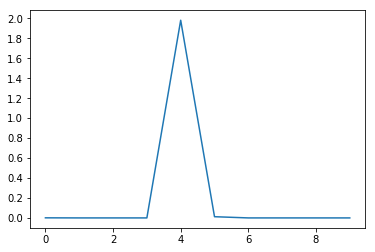

In [294]:
# 나머지뷰 (10802 dim)
inputs = morph_data
INPUT_SIZE = inputs.size()[1]

model_morph = SimpleAutoencoder(INPUT_SIZE).cuda(GPU_ID)
trainModel(model_morph, inputs, num_epoch=50)

In [295]:
# 나머지 뷰
# Train
inputs = Variable(cluster_morph_data).cuda(GPU_ID)
batch_rep = model_morph.getRepresentation(inputs).data.tolist()

KeyboardInterrupt: 

In [ ]:
kmeans_morph = KMeans(n_clusters=2, random_state=0).fit(batch_rep)
gen_label_morph = kmeans_morph.labels_

correct_cnt_morph = max(gen_label_morph[u20_doc_size:].tolist().count(0) + gen_label_morph[:u20_doc_size].tolist().count(1),
                        gen_label_morph[u20_doc_size:].tolist().count(1) + gen_label_morph[:u20_doc_size].tolist().count(0))
acc_morph = correct_cnt_morph / TOTAL_DATA_NUM
acc_morph

In [ ]:
gen_label_morph